- ## Escolha do modelo
- ## Treinamento do modelo
- ## Teste do modelo
- ## Armazenamento do modelo

In [34]:
# maximiza nro de linhas e colunas para exibição
# inibe mensagens de warning
import pandas as pd
pd.set_option('display.max_rows', None) # permite a máxima visualização das linhas em um display
pd.set_option('display.max_columns', None) # permite a máxima visualização das colunas em um display
import warnings
warnings.simplefilter('ignore') # inibe a exibição de avisos de warning
warnings.filterwarnings('ignore') # inibe a exibição de avisos de warning

In [35]:
# modelos de aprendizado por reforço
from keras.models import Sequential # O modelo Sequential é apropriado para uma pilha simples de camadas, onde cada camada tem exatamente um tensor de entrada e um tensor de saída.

from keras.models import load_model # função load_model do Keras é utilizada para carregar modelos que foram salvos anteriormente usando model.save(). Isso permite que você recupere modelos treinados do armazenamento para uso posterior.
from keras.layers import Dense # A camada Dense em Keras é uma camada de rede neural densamente conectada que realiza a operação: saída = ativação(dot(entrada, peso) + viés).
from keras.optimizers import Adam # Adam é um método que se adapta à taxa de aprendizado, sendo amplamente utilizado para otimização em modelos de aprendizado de máquina. 

In [36]:
# preparação e visualização de dados
import numpy as np # computação de matrizes
from matplotlib import pyplot as plt # plotagem gráfica

import datetime # O módulo datetime fornece classes para manipular datas e horários,
import random # é utilizado para gerar números pseudoaleatórios e realizar diversas operações de aleatorização, como escolher elementos aleatórios de uma lista.
from collections import deque # O deque, ou fila de duas extremidades, é uma estrutura de dados que permite a inserção e remoção eficiente de elementos em ambas as extremidades.

In [37]:
# carregando arquivo tratado em dataframe
df_soy = pd.read_csv('df_treated/df_soy_treated.csv')

In [38]:
# conferindo a dimensão do dataframe, linhas e colunas
df_soy.shape

(9276, 8)

In [39]:
# ordenando pelo index o dataframe carregado
df_soy = df_soy.sort_index()

In [40]:
# reconhecendo as primeiras linhas do dataframe
df_soy.head(5)

,Date,Open,High,Low,Close,Volume,Open_Interest,Year
0,1999-01-04,567.0,570.00,566.0,569.00,14.0,312.0,1999
1,1999-01-05,570.5,574.00,570.5,573.50,12.0,323.0,1999
2,1999-01-06,574.0,579.00,574.0,577.00,43.0,329.0,1999
3,1999-01-07,574.5,575.75,574.0,574.25,69.0,348.0,1999
4,1999-01-08,579.0,581.00,579.0,580.50,61.0,345.0,1999


In [41]:
# verificando as características de cada variável
df_soy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9276 entries, 0 to 9275
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9276 non-null   object 
 1   Open           9276 non-null   float64
 2   High           9276 non-null   float64
 3   Low            9276 non-null   float64
 4   Close          9276 non-null   float64
 5   Volume         9276 non-null   float64
 6   Open_Interest  9276 non-null   float64
 7   Year           9276 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 579.9+ KB


In [42]:
# verificando quantas cotações existem por ano
df_soy.Year.value_counts()

Year
2010    510
2019    510
2009    502
2016    502
2015    502
2013    502
2012    502
2014    501
2018    500
2017    499
2020    490
2011    469
2007    406
2008    354
2005    323
2006    320
2002    308
2004    280
2003    270
2000    267
2001    259
1999    251
2021    249
Name: count, dtype: int64

In [43]:
# modificando o tipo de Date para datetime
df_soy['Date'] = df_soy['Date'].astype('datetime64[ns]')

In [44]:
# separando somente um ano mais próximo e com mais cotações para o treino e teste
df_soy = df_soy.loc[df_soy['Date'].dt.year == 2020]

In [45]:
# criando uma lista dos valores das colunas que serão utilizadas para o treinamento e teste
X=list(df_soy['Close'])

In [46]:
# separando algumas linhas do final para fazer uma prévia rápida e conferir o código
#X= X[230:]

In [47]:
# separando as variáveis de treino(80%) e de teste(20%)
X=[float(x) for x in X] 
validation_size = 0.2 
train_size = int(len(X) * (1-validation_size)) 
X_train, X_test = X[0:train_size], X[train_size:len(X)]

In [48]:
# verificando quantas ocorrências de treino e de teste foram geradas
print(len(X_train))
print(len(X_test))

199
50


In [50]:
# verificando as primeiras ocorrências da lista de valores de treino
X_train[:10]

[1316.5,
 1350.0,
 1365.25,
 1360.5,
 1375.75,
 1374.5,
 1422.0,
 1411.0,
 1436.5,
 1161.5]

In [51]:
# verificando as primeiras ocorrências da lista de valores de teste
X_test[:10]

[1316.5,
 1350.0,
 1365.25,
 1360.5,
 1375.75,
 1374.5,
 1422.0,
 1411.0,
 1436.5,
 1161.5]

In [52]:
# declara a classe Agent
# instancia o modelo sequential
# treina e ajusta o modelo

class Agent: 
    def __init__(self, state_size, is_eval=False, model_name=''): 
        self.state_size = state_size # dias anteriores normalizados 
        self.action_size = 3 # hold, compra, venda 
        self.memory = deque(maxlen=1000) 
        self.inventory = [] 
        self.model_name = model_name 
        self.is_eval = is_eval 
        self.gamma = 0.95
        self.epsilon = 1.0 
        self.epsilon_min = 0.01 
        self.epsilon_decay = 0.995 
        self.model = load_model('models/' + model_name) if is_eval else self._model()

    def _model(self): 
        model = Sequential() 
        model.add(Dense(units=64, input_dim=self.state_size, activation='relu')) 
        model.add(Dense(units=32, activation='relu')) 
        model.add(Dense(units=8, activation='relu')) 
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001)) 
        return model     

    def act(self, state): 
        if not self.is_eval and random.random() <= self.epsilon: 
            return random.randrange(self.action_size)

        options = self.model.predict(state) 
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = [] 
        l = len(self.memory) 

        #1: preparar a replay memory 
        for i in range(l - batch_size + 1, l): 
            mini_batch.append(self.memory[i]) 

        #2: Fazer loop em todo o lote de replay. 
        for state, action, reward, next_state, done in mini_batch: 
            target = reward # recompensa ou Q no tempo t 

            #3: atualizar o alvo para tabela Q. equação de tabela
            if not done: 
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0]) #set_trace() 
            
            #4: Valor Q do estado atual a partir da tabela 
            target_f = self.model.predict(state) 
            
            #5: Atualizar a tabela Q de saída para a ação dada na tabela 
            target_f[0][action] = target 
            
            #6. Treinar e ajustar o modelo 
            self.model.fit(state, target_f, epochs=1, verbose=0)

            #7. Implementar algoritmo epsilon greedy 
            if self.epsilon > self.epsilon_min: 
                self.epsilon *= self.epsilon_decay

- As recompensas são computadas.
- Os pesos do modelo Q-learning baseado em aprendizado profundo são atualizados iterativamente ao longo de diversos episódios.
- O lucro e a perda de cada título são somados para determinar se um lucro geral ocorreu. 
- O objetivo é maximizar o lucro total.

- A função MODEL é um modelo de aprendizado profundo que conecta os estados com as ações.
- O modelo espera linhas de dados com números de variáveis iguais ao tamanho do estado, que chega como uma entrada.
- A primeira, a segunda e a terceira camadas ocultas têm 64, 32 e 8 nós, respectivamente, e todas essas camadas usam a função de ativação ReLU. 
- A camada de saída tem o número de nós igual ao tamanho da ação (três), e o nó usa uma função de ativação linear.

- A função ACT retorna uma ação dado um estado. Ela usa a função model e retorna uma ação de compra, venda ou hold.

- A função EXPREPLAY é a função-chave, na qual a rede neural é treinada com base na experiência observada. Essa função implementa o mecanismo replay de experiência. O replay de experiência armazena um histórico de estado, ação, recompensa e próximas transições de estado que são experienciadas pelo agente.
- A abordagem epsilon greedy implementada nessa função impede o sobreajuste.

In [53]:
# Calcula um valor entre 0 e 1 resultado da função sigmoide, usando um valor x passado.
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

- A função sigmoide é uma das funções de ativação mais conhecidas e se destaca por produzir resultados entre 0 e 1, concentrando valores próximos a essas extremidades.

In [54]:
# gera o estado considerando os dados da ação, o tempo t (dia da previsão) e a janela n (número de dias para voltar no tempo).
def getState(data, t, n): 
    d = t - n + 1 
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]

    res = [] 
    for i in range(n - 1): 
        res.append(sigmoid(block[i + 1] - block[i])) 
        
    return np.array([res])

In [55]:
# retorna a plotagem do preço de mercado juntamente com indicadores para as títulos de compra e de venda.
def plot_behavior(data_input, states_buy, states_sell, profit, titulo, nomearq):
    fig = plt.figure(figsize = (15, 5)) 
    plt.plot(data_input, color='gray', lw=2.) 
    plt.plot(data_input, '^', markersize=10, color='red', label='Comprar', markevery=states_buy) 
    plt.plot(data_input, 'v', markersize=10, color='blue', label='Vender', markevery = states_sell) 
    plt.title(titulo + ' - ' + nomearq + ' - Total ganho: %f'%(profit)) 
    plt.legend() 

    plt.savefig('grafic_image/' + nomearq + '.png', format='png')

    plt.show()

In [56]:
# recebe um valor float e retorna formatado com 2 decimais
def formatPrice(vr):
    return ("%.2f" % vr)

In [57]:
# cria dataframe de valores de fechamento original, se vende, se compra ou se mantem
df_modelo = {
    'vr_fechamento': [],
    'vr_buy': [],
    'vr_sell': [],
}

df_soy_action = pd.DataFrame(df_modelo)

In [58]:
# estancia e inicializa variáveis para o treino
window_size = 1
agent = Agent(window_size)
data = X_train # ....................
l = len(data) - 1 
batch_size = 10 
states_sell = [] 
states_buy = [] 
episode_count = 3 

In [59]:
# invoca o treinamento de alguns modelos cuja quantidade é do episode_count considerando iniciar em 0
# armazena os modelos treinados na pasta models
# para cada action retornado do agent exibe o resultado como uma ação de buy(comprar), sell(vender) ou hold(manter)
now = datetime.datetime.now()
print("INÍCIO DO TREINO - Data e hora atuais: ", now.strftime("%Y-%m-%d %H:%M:%S"))

for e in range(episode_count + 1): 
    print('Episode ' + str(e) + '/' + str(episode_count)) 
    
    # 1-obter estado 
    state = getState(data, 0, window_size + 1) 
    total_profit = 0.0 
    agent.inventory = []

    for t in range(l): 
        # 2-aplicar a melhor ação 
        action = agent.act(state) 

        print('***** state', state)
        print('***** action', action)

        # sit 
        next_state = getState(data, t + 1, window_size + 1) 
        reward = 0 
        bought_price = 0 # ....................
        if action == 1: # compra 
            agent.inventory.append(data[t]) 
            states_buy.append(t) 
            print('1 - Buy (comprar): ' + formatPrice(data[t]))
            dfx = pd.DataFrame({"vr_fechamento":[data[t]],"vr_buy":[data[t]],"vr_sell":['Nan']})
            df_soy_action = pd.concat([df_soy_action, dfx], ignore_index=True)

        elif action == 2 and len(agent.inventory) > 0: # venda
            bought_price = agent.inventory.pop(0) 
        
            #3: Obter Recompensa 
            reward = max(data[t] - bought_price, 0) 
            total_profit += data[t] - bought_price 
            states_sell.append(t) 
            print('2 - Sell (vender): ' + formatPrice(data[t]) + ' | Profit (lucro): ' + formatPrice(data[t] - bought_price))
            dfx = pd.DataFrame({"vr_fechamento":[data[t]],"vr_buy":['Nan'],"vr_sell":[data[t]]})
            df_soy_action = pd.concat([df_soy_action, dfx], ignore_index=True)

            print('Total do Lucro: ' + formatPrice(total_profit)) 

        else:
            #print('3 - Hold (manter): ' + formatPrice(data[t]))  
            dfx = pd.DataFrame({"vr_fechamento":[data[t]],"vr_buy":['Nan'],"vr_sell":['Nan']})
            df_soy_action = pd.concat([df_soy_action, dfx], ignore_index=True)              

        done = True if t == l - 1 else False 
        
        # 4: Obter próximo estado a ser usado na equação de Bellman 
        next_state = getState(data, t + 1, window_size + 1) 
        
        # 5: Acrescentar à memória 
        agent.memory.append((state, action, reward, next_state, done)) 
        state = next_state 

        print('e: ' + str(e) + ' | l: ' + str(l) + ' | t: ' + str(t) + ' | action: ' + str(action) + \
              ' | bought_price: ' + formatPrice(bought_price)) 
        print('lent(agent.memory): ' + str(len(agent.memory)) + ' | batch_size: ' + str(batch_size))

        # 6: Executar função replay buffer 
        if len(agent.memory) > batch_size: 
            agent.expReplay(batch_size) 

        if e % 10 == 0: 
            agent.model.save('models/model_ep' + str(e) + '.keras')

        if done: 
            print('--------------------------------')
            print('Total do Lucro: ' + formatPrice(total_profit)) 
            print('--------------------------------') 

    agent.model.save('models/model_ep' + str(e) + '.keras')

    # plotando o resultado do treino
    plot_behavior(data, states_buy, states_sell, total_profit, 'Resultado do Treino', 'model_ep' + str(e) + '_treino')
    
now = datetime.datetime.now()
print("FIM DO TREINO - Data e hora atuais: ", now.strftime("%Y-%m-%d %H:%M:%S"))

INÍCIO DO TREINO - Data e hora atuais:  2025-01-16 18:19:54
Episode 0/3
***** state [[0.5]]
***** action 0
e: 0 | l: 198 | t: 0 | action: 0 | bought_price: 0.00
lent(agent.memory): 1 | batch_size: 10
***** state [[1.]]
***** action 2
e: 0 | l: 198 | t: 1 | action: 2 | bought_price: 0.00
lent(agent.memory): 2 | batch_size: 10
***** state [[0.99999976]]
***** action 1
1 - Buy (comprar): 1365.25
e: 0 | l: 198 | t: 2 | action: 1 | bought_price: 0.00
lent(agent.memory): 3 | batch_size: 10
***** state [[0.00857749]]
***** action 2
2 - Sell (vender): 1360.50 | Profit (lucro): -4.75
Total do Lucro: -4.75
e: 0 | l: 198 | t: 3 | action: 2 | bought_price: 1365.25
lent(agent.memory): 4 | batch_size: 10
***** state [[0.99999976]]
***** action 0
e: 0 | l: 198 | t: 4 | action: 0 | bought_price: 0.00
lent(agent.memory): 5 | batch_size: 10
***** state [[0.22270014]]
***** action 0
e: 0 | l: 198 | t: 5 | action: 0 | bought_price: 0.00
lent(agent.memory): 6 | batch_size: 10
***** state [[1.]]
***** actio

KeyboardInterrupt: 

In [26]:
# Faz o teste do modelo passado utilizando os valores da lista de teste X_test
# o agente já está definido no conjunto de teste precedente. 
# para cada action retornado do agent exibe o resultado como uma ação de buy(comprar), sell(vender) ou
# hold(manter)
states_sell_test = [] 
states_buy_test = []
total_profit = 0.0 
test_data = X_test 

def testa_modelos(X_test, window_size, model_name, nome_grafico):
    global df_soy_action
    global test_data
    l_test = len(test_data) - 1 
    state = getState(test_data, 0, window_size + 1) 
    global total_profit
    is_eval = True 
    done = False 
    global states_sell_test
    global states_buy_test
    model_name = model_name #'model_ep3.keras'
    agent = Agent(window_size, is_eval, model_name) 
    state = getState(data, 0, window_size + 1) 
    total_profit = 0.0 
    agent.inventory = [] 

    for t in range(l_test): 
        action = agent.act(state) 
        next_state = getState(test_data, t + 1, window_size + 1) 
        reward = 0 

        print('***** state', state)
        print('***** action', action)

        if action == 1:
            agent.inventory.append(test_data[t]) 
            states_buy_test.append(t) 
            print('Buy (comprar): ' + formatPrice(test_data[t])) 
            dfx = pd.DataFrame({"vr_fechamento":[data[t]],"vr_buy":[data[t]],"vr_sell":['Nan']})
            #df_soy_action = pd.concat([df_soy_action, dfx], ignore_index=True)

        elif action == 2 and len(agent.inventory) > 0: 
            bought_price = agent.inventory.pop(0) 
            reward = max(test_data[t] - bought_price, 0) 
            total_profit += test_data[t] - bought_price
            states_sell_test.append(t)
            print('Sell (vender): ' + formatPrice(test_data[t]) + ' | profit (lucro): ' + formatPrice(test_data[t] - bought_price)) 
            dfx = pd.DataFrame({"vr_fechamento":[data[t]],"vr_buy":['Nan'],"vr_sell":[data[t]]})
            #df_soy_action = pd.concat([df_soy_action, dfx], ignore_index=True)       

            print('Total do Lucro: ' + formatPrice(total_profit))

        else:
            #print('3 - Hold (manter): ' + formatPrice(test_data[t]))  
            dfx = pd.DataFrame({"vr_fechamento":[data[t]],"vr_buy":['Nan'],"vr_sell":['Nan']})
            #df_soy_action = pd.concat([df_soy_action, dfx], ignore_index=True)                   

        if t == l_test - 1: 
            done = True 
            agent.memory.append((state, action, reward, next_state, done)) 
            state = next_state 

        if done: 
            print('------------------------------------------')
            print('Total do Lucro: ' + formatPrice(total_profit)) 
            print('------------------------------------------')

    # plotando o resultado do treino
    plot_behavior(test_data, states_buy_test, states_sell_test, total_profit, 'Resultado do Teste', nome_grafico)

INÍCIO DO TESTE - Data e hora atuais:  2025-01-16 17:46:29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
***** state [[0.5]]
****

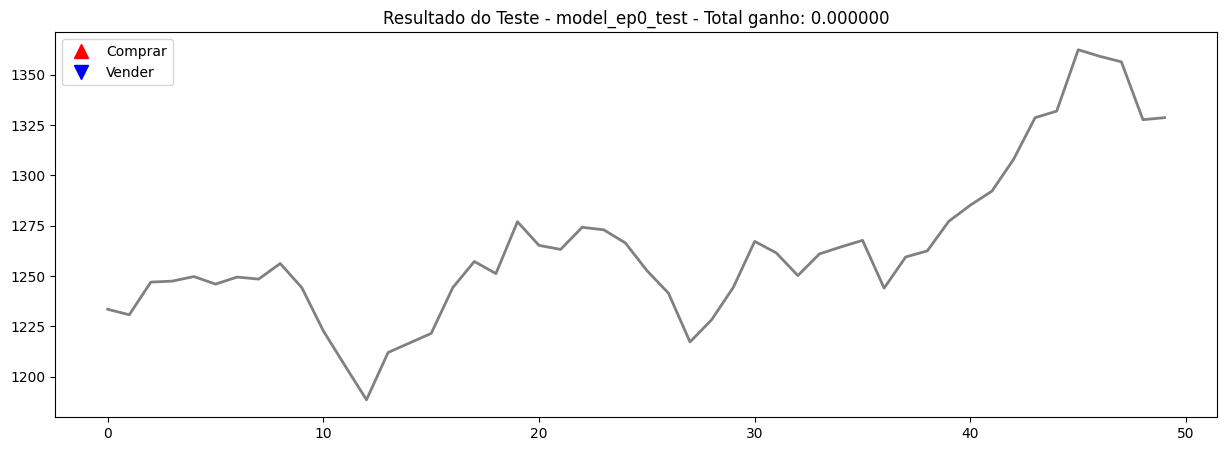

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
***** stat

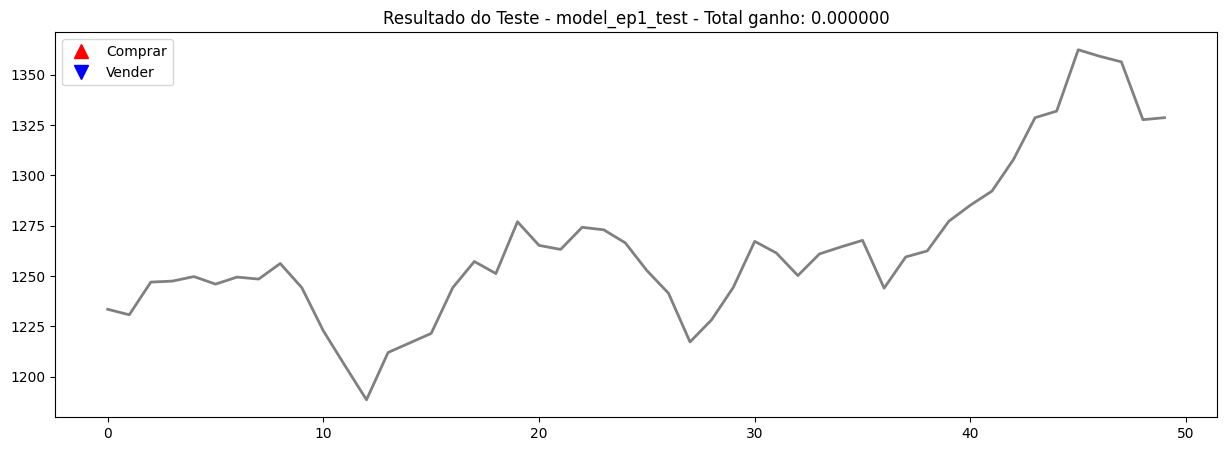

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
***** stat

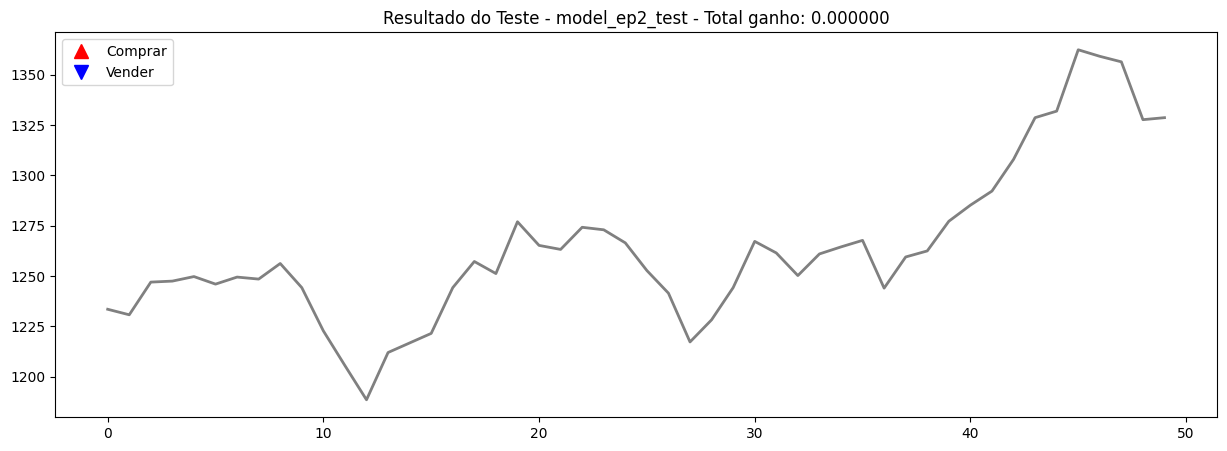

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
***** state [[0.5]]
***** action 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
***** stat

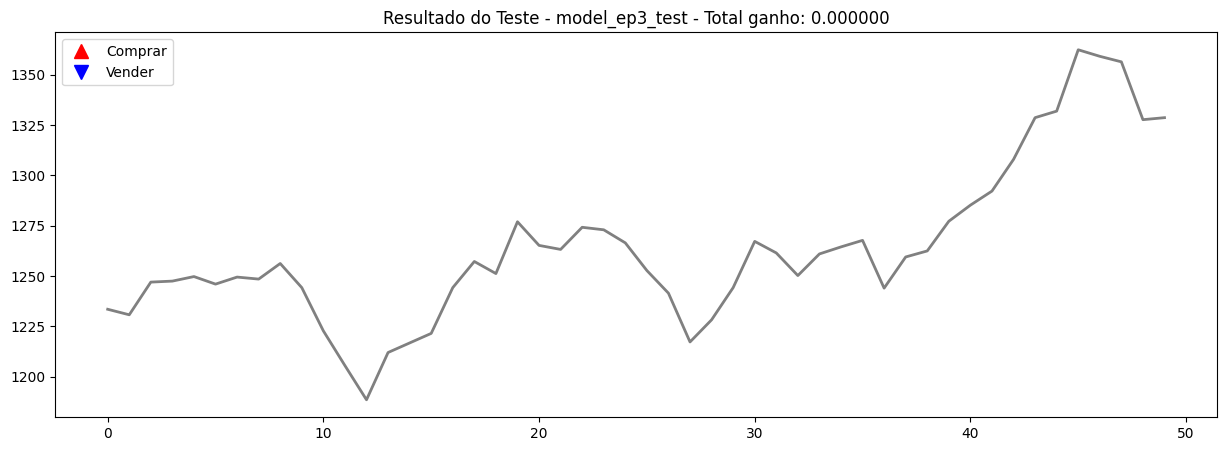

FIM DO TESTE - Data e hora atuais:  2025-01-16 17:47:09


In [ ]:
# invoca a função testa_modelos para o teste de predição para todos os modelos treinados
now = datetime.datetime.now()
print("INÍCIO DO TESTE - Data e hora atuais: ", now.strftime("%Y-%m-%d %H:%M:%S"))

for i in range(episode_count+1):
    nome_grafico = 'model_ep' + str(i) + '_test'
    model_name = 'model_ep' + str(i) + '.keras'
    testa_modelos(X_test, window_size, model_name, nome_grafico)

now = datetime.datetime.now()
print("FIM DO TESTE - Data e hora atuais: ", now.strftime("%Y-%m-%d %H:%M:%S"))

In [28]:
# verificando as variáveis do dataframe action gerado no treino
df_soy_action.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vr_fechamento  792 non-null    float64
 1   vr_buy         792 non-null    object 
 2   vr_sell        792 non-null    object 
dtypes: float64(1), object(2)
memory usage: 18.7+ KB


In [29]:
# modifica o tipo de variável
df_soy_action['vr_buy'] = df_soy_action['vr_buy'].astype('float')
df_soy_action['vr_sell'] = df_soy_action['vr_sell'].astype('float')

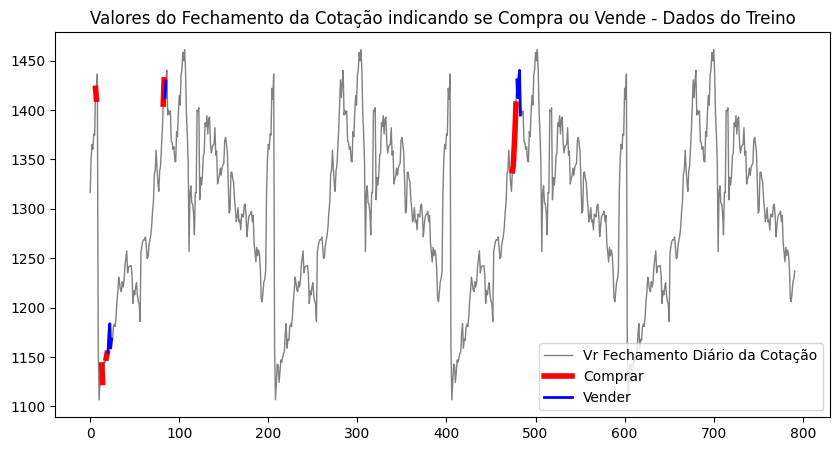

In [ ]:
# plotando a evolução de valores de fechamento indicando se compra ou vende
fig,ax = plt.subplots(ncols=1,figsize=(10,5))

plt.plot(df_soy_action.index, \
         df_soy_action.vr_fechamento, label = "Vr Fechamento Diário da Cotação", linewidth=1, color='gray') 
plt.plot(df_soy_action.index, \
         df_soy_action.vr_buy, label = "Comprar", linewidth=4, color='red') 
plt.plot(df_soy_action.index, \
         df_soy_action.vr_sell, label = "Vender", linewidth=2, color='blue')  

plt.title('Valores do Fechamento da Cotação indicando se Compra ou Vende - Dados do Treino')
plt.legend() 

plt.yscale('linear')

plt.savefig('grafic_image/models_treino.png', format='png')
plt.show()

- No gráfico podemos observar que cada pico que se repete representa o resultado da aplicação de um modelo, temos 4 modelos treinados. No final do gráfico temos alguns valores repetitivos menores que representam o resultado da aplicação dos dados de teste nos quatro modelos treinados.

<function matplotlib.pyplot.show(close=None, block=None)>

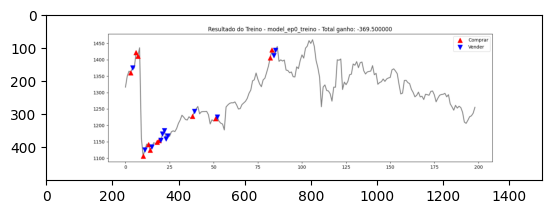

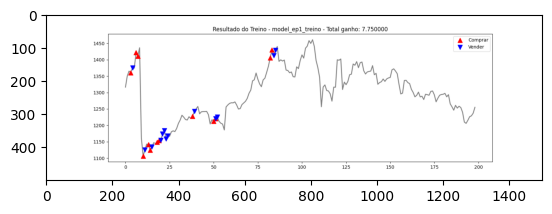

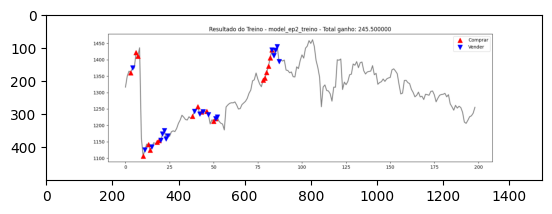

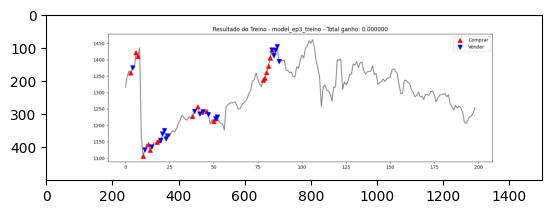

In [ ]:
# exibe os gráficos de treino para cada modelo
import matplotlib.image as mpimg

for i in range(episode_count+1): 
    nome_grafico = 'model_ep' + str(i) + '_treino'
    plt.figure()
    plt.imshow(mpimg.imread('grafic_image/' + nome_grafico + '.png'))

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

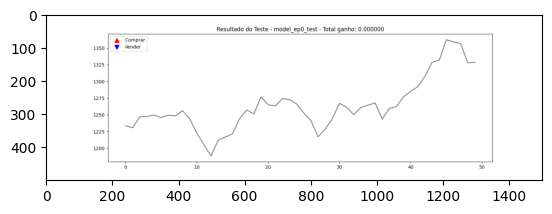

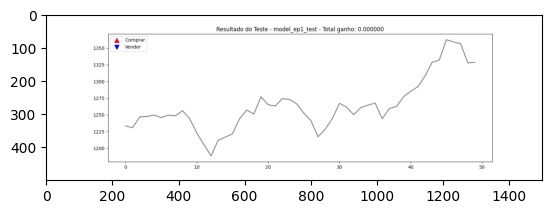

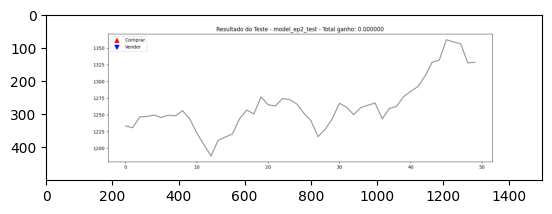

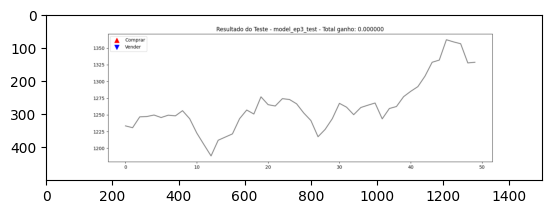

In [ ]:
# exibe os gráficos de teste para cada modelo
for i in range(episode_count+1):
    nome_grafico = 'model_ep' + str(i) + '_test'
    plt.figure()
    plt.imshow(mpimg.imread('grafic_image/' + nome_grafico + '.png'))

plt.show